In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

In [3]:
files=['hdfc.csv','itc.csv','l&t.csv','m&m.csv','sunpha.csv','tcs.csv']
dfs=[]

for file in files:
    temp=pd.read_csv('Stocks_Data/' + file)
    temp.columns=['Date',file.replace('.csv','')]
    dfs.append(temp)

stocks = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
print(stocks.shape)
stocks.head()

(37, 7)


,Date,hdfc,itc,l&t,m&m,sunpha,tcs
0,June 2018,2108.05,266.05,1271.3,896.80,560.55,1847.20
1,May 2018,2136.15,271.60,1367.6,923.50,480.15,1744.80
2,Apr 2018,1944.60,281.45,1400.6,872.65,528.15,1765.70
3,Mar 2018,1891.45,255.90,1311.9,740.20,495.40,1424.65
4,Feb 2018,1883.80,265.10,1319.1,728.75,535.35,1519.13


In [4]:
def hist_return(months):
    ''' It calculates Stock returns for various months and returns a dataframe.
        Input: Months in the form of a list.
        Output: Historical returns in the form of a DataFrame. '''
    idx=[]
    df=pd.DataFrame()
    for mon in months:
        temp=(stocks.iloc[0,1:] - stocks.iloc[mon,1:])/(stocks.iloc[mon,1:])
        idx.append(str(mon)+' Month Return')
        df=pd.concat([df, temp.to_frame().T], ignore_index=True)
    df.index=idx
    return df

In [5]:
hist_stock_returns=hist_return([3,6,12,24,36])
cols=hist_stock_returns.columns
hist_stock_returns[cols] = hist_stock_returns[cols].apply(pd.to_numeric, errors='coerce')
# Calculate covariance of historical returns
cov_hist_return=hist_stock_returns.cov()
# For ease of calculations make covariance of same variable as zero.
for i in range(6):
    cov_hist_return.iloc[i][i]=0
# Calculate the mean of historical returns
mean_hist_return=hist_stock_returns.mean()
# Calculate Standard deviation of historical returns:
sd_hist_return=hist_stock_returns.std()

In [6]:
def mean_portfolio_return(weights):
    return np.sum(np.multiply(weights,mean_hist_return))

def var_portfolio_return(weights):
    part_1 = np.sum(np.multiply(weights,sd_hist_return)**2)
    temp_lst=[]
    for i in range(6):
        for j in range(6):
            temp=cov_hist_return.iloc[i][j] * weights[i] * weights[j]
            temp_lst.append(temp)
    part_2=np.sum(temp_lst)
    return part_1+part_2

rf = 0.0667
rf_alternative = 0.2

def fitness_function(weights, rf = rf, lower = 1e-3):
    """Calculate portfolio fitness for given weights"""
    return (mean_portfolio_return(weights)-rf)/np.sqrt(np.max([var_portfolio_return(weights), lower]))

In [7]:
# Generates random answer in bound[a,b] with sum 1
def random_weights(n, a = -1, b = 1):
    k = np.random.uniform(a, b, (n))
    while(np.sum(k) < 1):
        k = np.random.uniform(a, b, (n))
    return k / np.sum(k)

In [8]:
def sa(dim = 6, bound = [-1, 1], n_iter=10000, initial_temp=1000, cool_rate=0.95, rf = rf, lower = 1e-3, showlog = False):
    """Solve portfolio optimization problem using simulated annealing"""
    
    # initialize variables
    m = n_iter
    current_weights = random_weights(dim, bound[0], bound[1])  # initial weights
    best_weights = current_weights.copy()  # best observed weights
    current_fitness = fitness_function(current_weights, rf , lower)  # initial return
    best_fitness = current_fitness  # best observed return

    # iterate for m iterations
    for i in range(m):
        # decrease temperature
        temp = initial_temp * (cool_rate ** i)

        # generate new candidate
        candidate_weights = random_weights(dim, bound[0], bound[1])
        candidate_fitness = fitness_function(candidate_weights, rf , lower)

        # calculate acceptance probability
        delta = candidate_fitness - current_fitness
        if delta >= 0:
            accept_prob = 1.0
        else:
            accept_prob = np.exp(delta / temp)

        # update weights and return
        if np.random.rand() < accept_prob:
            current_weights = candidate_weights
            current_fitness = candidate_fitness

        # update best weights and return
        if current_fitness > best_fitness:
            best_weights = current_weights.copy()
            best_fitness = current_fitness
        if showlog:
            print('Iteration:',i)
            print('Expected returns of {} with risk of {}\n'.format(mean_portfolio_return(best_weights), var_portfolio_return(best_weights)))
        

    # return best weights and return
    return best_weights, best_fitness, var_portfolio_return(best_weights), mean_portfolio_return(best_weights)

In [19]:
sol, fit, risk, ret = sa(dim = 6, n_iter = 10000, bound = [-1,1], initial_temp=1000, cool_rate=0.95, rf = rf, lower = 1e-3, showlog = True)

Iteration: 0
Expected returns of 0.16320673276931197 with risk of 0.0023314693812493247

Iteration: 1
Expected returns of 0.16320673276931197 with risk of 0.0023314693812493247

Iteration: 2
Expected returns of 0.47918678066443665 with risk of 0.03361820182829517

Iteration: 3
Expected returns of 0.3313016659866441 with risk of 0.011716952622046386

Iteration: 4
Expected returns of 0.3313016659866441 with risk of 0.011716952622046386

Iteration: 5
Expected returns of 0.3313016659866441 with risk of 0.011716952622046386

Iteration: 6
Expected returns of 0.3313016659866441 with risk of 0.011716952622046386

Iteration: 7
Expected returns of 0.3313016659866441 with risk of 0.011716952622046386

Iteration: 8
Expected returns of 0.3313016659866441 with risk of 0.011716952622046386

Iteration: 9
Expected returns of 0.3313016659866441 with risk of 0.011716952622046386

Iteration: 10
Expected returns of 0.2974235876147832 with risk of 0.005152480121258195

Iteration: 11
Expected returns of 0.29

In [20]:
print('Portfolio of stocks:')
for i in list(range(6)):
    print(hist_stock_returns.columns[i],':',sol[i]) 
print('\nExpected returns of ', ret, "with risk of ", risk, "and fitness ", fit)

Portfolio of stocks:
hdfc : -0.15455278360797878
itc : 0.39757605943971025
l&t : -0.011225916765081508
m&m : -0.20503044008391394
sunpha : 0.08312408753294676
tcs : 0.8901089934843173

Expected returns of  0.2587531504962975 with risk of  0.0013950797466072227 and fitness  5.141879786856711


In [11]:
parameters = [(rf, -1, 1, 1e-3), (rf, 0, 1, 1e-3), (rf_alternative, -1, 1, 1e-3), (rf_alternative, 0, 1, 1e-3), (rf, -1, 1, 1e-4), (rf, 0, 1, 1e-4), (rf_alternative, -1, 1, 1e-4), (rf_alternative, 0, 1, 1e-4)]
solutions = np.reshape([[sa(bound=[x[1], x[2]], dim=6, n_iter=1000, initial_temp=100, cool_rate=0.95, rf = x[0], lower = x[3])[2:] for _ in range(50)] for x in parameters], (8,50,2))

In [ ]:
# Use this cell instead of the one above to quickly use values to render the plot
parameters = [(rf, -1, 1, 1e-3), (rf, 0, 1, 1e-3), (rf_alternative, -1, 1, 1e-3), (rf_alternative, 0, 1, 1e-3), (rf, -1, 1, 1e-4), (rf, 0, 1, 1e-4), (rf_alternative, -1, 1, 1e-4), (rf_alternative, 0, 1, 1e-4)]
s = [[[ 0.0009412310291727188 ,  0.20571759098703624 ], [ 0.0009823838259397375 ,  0.2174959292243307 ], [ 0.0008403239802978607 ,  0.18980977404969965 ], [ 0.00235830412120867 ,  0.28151999218641555 ], [ 0.0033842781446106543 ,  0.3301084085516509 ], [ 0.0013344522483100356 ,  0.22370159014556976 ], [ 0.006140441042649256 ,  0.39046631299087375 ], [ 0.0050384919694230895 ,  0.3528468207446373 ], [ 0.0009454225624649353 ,  0.19328339754055307 ], [ 0.005496030975687433 ,  0.38478708936776107 ], [ 0.0027042158691475272 ,  0.2581752342320551 ], [ 0.001826985638260273 ,  0.23928258051890783 ], [ 0.0008798827312350935 ,  0.20406896459031335 ], [ 0.0010381173704268462 ,  0.2308233685175386 ], [ 0.000780083419684937 ,  0.2639285272159341 ], [ 0.0018836319456914524 ,  0.23712639461007357 ], [ 0.0019451471702724137 ,  0.276261927830733 ], [ 0.0032544962430236385 ,  0.29481776370234564 ], [ 0.0035245264196713828 ,  0.33236172301789496 ], [ 0.0016422407459361285 ,  0.2554652227940684 ], [ 0.0015169258897997258 ,  0.23391608812914233 ], [ 0.0018506068329673803 ,  0.2599973406625433 ], [ 0.0012523557567463775 ,  0.2425053121909009 ], [ 0.0033952104534670548 ,  0.3307793996615266 ], [ 0.0008366539944080313 ,  0.22803728924709907 ], [ 0.0011132188961124646 ,  0.26013250673905697 ], [ 0.0007494728823310981 ,  0.21601336493869885 ], [ 0.002261460307292844 ,  0.29924655844363607 ], [ 0.002796401634214081 ,  0.29285339475912286 ], [ 0.003296770655848321 ,  0.2943808589877567 ], [ 0.001548267869787203 ,  0.236678290086366 ], [ 0.0012220924048921538 ,  0.23139329274999754 ], [ 0.0009633547921357394 ,  0.19110528363558396 ], [ 0.001453983308383762 ,  0.22242189337250157 ], [ 0.002200269607897525 ,  0.2623561726540956 ], [ 0.0008711338902546101 ,  0.19864825991658835 ], [ 0.0008118449403004512 ,  0.20607694836928878 ], [ 0.002075954432813852 ,  0.27005591046007 ], [ 0.0009558027659837317 ,  0.19291266369355844 ], [ 0.0011979189628984277 ,  0.21621329036242684 ], [ 0.002077657420575113 ,  0.2796617835993952 ], [ 0.0009002122697691628 ,  0.22013686999206886 ], [ 0.0014532010780097812 ,  0.22937329764588424 ], [ 0.002004419539970395 ,  0.26776980542502593 ], [ 0.001878183212298731 ,  0.25410092224727904 ], [ 0.001365012436710237 ,  0.21414901098907385 ], [ 0.010300467775252321 ,  0.44821349463647964 ], [ 0.010230473223386317 ,  0.4325958422472874 ], [ 0.0011515266804112173 ,  0.20280812148796465 ], [ 0.0011014206668150638 ,  0.2362058715284925 ]], 
[[ 0.0017212987302671848 ,  0.22541170310620628 ], [ 0.002208143141846464 ,  0.2562801422625759 ], [ 0.0009829336601335577 ,  0.18131345202159915 ], [ 0.0007649169769373405 ,  0.192080391768982 ], [ 0.0010975526413262203 ,  0.19317663622250925 ], [ 0.0009714742528773605 ,  0.18396255974618209 ], [ 0.0010961216470598764 ,  0.1992525652254582 ], [ 0.0008490677333979658 ,  0.18632082288544408 ], [ 0.002642315982221663 ,  0.2665291826005129 ], [ 0.001276430175447374 ,  0.20940247029764864 ], [ 0.0014738379888083776 ,  0.21550571648113592 ], [ 0.0013233975145666536 ,  0.2133823353645969 ], [ 0.0014067548324499025 ,  0.21586833936394606 ], [ 0.0013411605838532358 ,  0.21080649733488802 ], [ 0.001108646004578833 ,  0.2119395606638941 ], [ 0.0012263393291408256 ,  0.2021009899392849 ], [ 0.0012957597046397312 ,  0.22243287517910548 ], [ 0.0012803411115855307 ,  0.21841427313266348 ], [ 0.001849048239453833 ,  0.23264456393129684 ], [ 0.001049524457084516 ,  0.18627099094970917 ], [ 0.001409219452564669 ,  0.21066000241182734 ], [ 0.0010337556771458176 ,  0.19584518458422692 ], [ 0.0006280544160422634 ,  0.18166848545668518 ], [ 0.0011357119663373215 ,  0.20312527511335954 ], [ 0.0017176942077808807 ,  0.23607332559445882 ], [ 0.001460347832966541 ,  0.2139927499820127 ], [ 0.0010008360032157425 ,  0.1955861463171883 ], [ 0.0011451726612036234 ,  0.19929608978260457 ], [ 0.001031477079563469 ,  0.20697138954880584 ], [ 0.001862381778851543 ,  0.23767486838406243 ], [ 0.0011583155774685513 ,  0.2086036726023969 ], [ 0.001021992539906614 ,  0.18675896522782265 ], [ 0.0008085168199983622 ,  0.19211961040249945 ], [ 0.0010550896770073143 ,  0.19245110786924768 ], [ 0.0017578189177905224 ,  0.23471668317314104 ], [ 0.000795373578702835 ,  0.18897826382248176 ], [ 0.0009518889480266413 ,  0.18215198377470887 ], [ 0.001264785671081433 ,  0.21514862004089097 ], [ 0.001395433206349217 ,  0.2200496834254848 ], [ 0.001232964064771829 ,  0.1979842288439842 ], [ 0.0011310347294735427 ,  0.1998980423335012 ], [ 0.0007840050738899627 ,  0.18197494709115075 ], [ 0.0013776450539400215 ,  0.20834336483323448 ], [ 0.0023011808368209284 ,  0.2533367499885253 ], [ 0.0017713215533809593 ,  0.22459411133693125 ], [ 0.0010346126880118487 ,  0.19880445140372202 ], [ 0.0011782911150045629 ,  0.1987049204538185 ], [ 0.0010709537498742915 ,  0.19451165444199608 ], [ 0.0012361313337148827 ,  0.20559296113680808 ], [ 0.0009791697837029153 ,  0.19490787237402124 ]], 
[[ 0.02622909794177214 ,  0.5524447461460547 ], [ 0.015829018145474955 ,  0.5218767605080871 ], [ 0.019298148256166672 ,  0.5249722820208153 ], [ 0.007828964016322281 ,  0.4041862455849916 ], [ 0.019894994838273818 ,  0.5177993566060558 ], [ 0.005202271452993668 ,  0.36268752192078885 ], [ 0.01594188762070707 ,  0.5321262476008344 ], [ 0.024756385390691173 ,  0.578511958975361 ], [ 0.018643902897995564 ,  0.5629751482862839 ], [ 0.012678221809737853 ,  0.47079073064242344 ], [ 0.022320979412707227 ,  0.540532642333549 ], [ 0.007266887124798036 ,  0.38960864193381073 ], [ 0.04133286986476318 ,  0.6962235421639951 ], [ 0.03141063038633454 ,  0.6214743273810897 ], [ 0.015277712376508486 ,  0.4921687452538758 ], [ 0.01239803511335033 ,  0.45020016235017224 ], [ 0.02542885656453732 ,  0.579331348289836 ], [ 0.04853838520690458 ,  0.7173137805786172 ], [ 0.005291896979927116 ,  0.3899211005008365 ], [ 0.018623649529243537 ,  0.5349751850138109 ], [ 0.020230432297810075 ,  0.5340619939954545 ], [ 0.02524243615122469 ,  0.5970445738956871 ], [ 0.01457129047030093 ,  0.4935445492078028 ], [ 0.02317647764423692 ,  0.6289878086024738 ], [ 0.015305959923539617 ,  0.5217388012203938 ], [ 0.03383841917338906 ,  0.626883186451862 ], [ 0.014707832333412954 ,  0.5090170811771693 ], [ 0.020623239122253913 ,  0.5525510793149508 ], [ 0.013549788008301797 ,  0.4997533972366098 ], [ 0.015939459450047017 ,  0.48153931137749884 ], [ 0.021060698467692856 ,  0.5819243596697632 ], [ 0.017322017527005382 ,  0.4988013917485654 ], [ 0.01760508584235036 ,  0.5180089214109389 ], [ 0.009623813126759983 ,  0.418564303486408 ], [ 0.01778968549472306 ,  0.5212449490253807 ], [ 0.027895222745827956 ,  0.6081326056302498 ], [ 0.026598800136752858 ,  0.6364204267743647 ], [ 0.009339459496010477 ,  0.4403361044973031 ], [ 0.03723507760185327 ,  0.6738184521474899 ], [ 0.016952642345715672 ,  0.5426024350609538 ], [ 0.03583454285857091 ,  0.6359616283500997 ], [ 0.02791978117906241 ,  0.5747529334653749 ], [ 0.011322415314260502 ,  0.4731768876510378 ], [ 0.03439313733591727 ,  0.6380207067128663 ], [ 0.006153528986167139 ,  0.36392550022872727 ], [ 0.016719744815263934 ,  0.4990672930180648 ], [ 0.022175099470155286 ,  0.4946727794229678 ], [ 0.01305379674394148 ,  0.4903366615569814 ], [ 0.022747867195431697 ,  0.6050896942519474 ], [ 0.0334037604340673 ,  0.6464548472243188 ]], 
[[ 0.0032154140649382004 ,  0.28418716912434067 ], [ 0.010761716614488713 ,  0.3578978526819312 ], [ 0.00551761744563766 ,  0.32590754726568005 ], [ 0.005871039099727664 ,  0.2956048269054474 ], [ 0.01436236108748477 ,  0.35504235583530536 ], [ 0.012518421367412704 ,  0.34361884151828703 ], [ 0.007875907146046485 ,  0.3233045751949928 ], [ 0.011852170011617525 ,  0.3434695572422469 ], [ 0.0045471316603492955 ,  0.28059224646550707 ], [ 0.004987756162951396 ,  0.3038279815799211 ], [ 0.009272723857809126 ,  0.3293401595604796 ], [ 0.0036086665731014343 ,  0.27429660683634266 ], [ 0.00718595741801948 ,  0.3206223986204816 ], [ 0.004698678102003229 ,  0.2917891524534101 ], [ 0.008633221105441931 ,  0.35446124674168306 ], [ 0.00799968634879837 ,  0.32875898642638957 ], [ 0.007075350926771645 ,  0.3182742410550101 ], [ 0.0034165289883554026 ,  0.2839771011479141 ], [ 0.014045822579386568 ,  0.34822044919013967 ], [ 0.003873215804293384 ,  0.2741106541539984 ], [ 0.007745248702306542 ,  0.31875872079906803 ], [ 0.006292350046611675 ,  0.3119632832172211 ], [ 0.004798046771481596 ,  0.3008743995897274 ], [ 0.011183456806970419 ,  0.3389779795216056 ], [ 0.015310396556933076 ,  0.34729533063071183 ], [ 0.008424943457878933 ,  0.2949711624294836 ], [ 0.00787019295961082 ,  0.3127539839798086 ], [ 0.009773987418483026 ,  0.3209547942129464 ], [ 0.006622911971495243 ,  0.3047695035282826 ], [ 0.006075413025507844 ,  0.2981906725342416 ], [ 0.005601326435731809 ,  0.29004600854847074 ], [ 0.007870086366166623 ,  0.33872011471130925 ], [ 0.010152942457357367 ,  0.3462605642549554 ], [ 0.0047314611452321945 ,  0.2954772181430419 ], [ 0.011455416265533277 ,  0.33381321707127115 ], [ 0.00409109576248376 ,  0.29289675145853383 ], [ 0.0032189164595534166 ,  0.27258369059410736 ], [ 0.005892908391488863 ,  0.31401600455404144 ], [ 0.008144555876593067 ,  0.3520697685894907 ], [ 0.005992736408342682 ,  0.2952417732233369 ], [ 0.006460656914792806 ,  0.32338114834531584 ], [ 0.010902305159272067 ,  0.33028219509216017 ], [ 0.00786038465878573 ,  0.3088544547398844 ], [ 0.0036560114358527686 ,  0.2876185814813088 ], [ 0.009368211458952166 ,  0.31267923787538776 ], [ 0.00594130457397644 ,  0.30963168806335084 ], [ 0.004707780335020593 ,  0.2935398527906896 ], [ 0.008621663207130644 ,  0.34803929424740043 ], [ 0.00628293259474372 ,  0.2849059336061802 ], [ 0.00671124709401631 ,  0.3059874609903212 ]], 
[[ 0.001190042691274689 ,  0.265676314000542 ], [ 0.0007319579000824722 ,  0.1856482803498423 ], [ 0.00013954437251232146 ,  0.18885550753347966 ], [ 0.0007121882930826726 ,  0.198557089986346 ], [ 0.00022894293119439177 ,  0.17656386434553784 ], [ 0.00042539344294665465 ,  0.18998721760062148 ], [ 0.0008384219808999331 ,  0.2572016362553574 ], [ 0.00012466579296057517 ,  0.17734567651184238 ], [ 0.001002972357013028 ,  0.21520061527930323 ], [ 0.00022337083808863806 ,  0.15229939618831564 ], [ 0.00032276266996637045 ,  0.15252645986788205 ], [ 0.0003358335300763064 ,  0.17003010530133214 ], [ 3.801378525599211e-05 ,  0.14475555059119682 ], [ 0.0010701633949266494 ,  0.23029944417577775 ], [ 0.00022383846715897607 ,  0.1282125192015539 ], [ 0.0012133910826845878 ,  0.20585816149916034 ], [ 0.0036601152915105295 ,  0.31366459841701316 ], [ 0.0017943553231544798 ,  0.2827474506215657 ], [ 0.002032350306060844 ,  0.24510472229138625 ], [ 0.0002583777768378776 ,  0.17924915002065894 ], [ 0.0004450209467426053 ,  0.1623019943616375 ], [ 0.00018471058636621365 ,  0.12105533066583075 ], [ 0.00014604691925016594 ,  0.160050045725962 ], [ 0.0003303017870375331 ,  0.1544058857612505 ], [ 0.0008416239993777226 ,  0.192582206167715 ], [ 0.000832462434430005 ,  0.22651521077872724 ], [ 0.0008374533242169989 ,  0.21184903701535585 ], [ 0.00037359182762628645 ,  0.17613157342371327 ], [ 0.0023704732705294163 ,  0.2879861635991816 ], [ 0.0007464650288577339 ,  0.19093145265169842 ], [ 0.006889125717640887 ,  0.40441291016351333 ], [ 0.0001680290970448705 ,  0.12734253762240208 ], [ 0.0004295114331531796 ,  0.17312902481327166 ], [ 0.0005199111213135196 ,  0.19791254311260123 ], [ 0.001083134392346627 ,  0.22802038117364387 ], [ 0.00035793638984607176 ,  0.1451213721862898 ], [ 0.0002989650354664683 ,  0.1619090389239686 ], [ 0.00011615885003111483 ,  0.11671940462529636 ], [ 0.000514072249992165 ,  0.17416991362201084 ], [ 0.0006945222644813157 ,  0.20455810766865543 ], [ 0.000925786878351386 ,  0.24400012831544718 ], [ 0.003516971892918612 ,  0.28554820308119533 ], [ 0.0006887668125547244 ,  0.18805634864916454 ], [ 0.0004253705418541878 ,  0.1599465716671432 ], [ 6.778269458101657e-05 ,  0.14376476792185972 ], [ 0.0006610018535821646 ,  0.1946426932949821 ], [ 0.0006306154495592953 ,  0.2500952947416356 ], [ 0.0001488858738700246 ,  0.1316744588845148 ], [ 0.00031031369356573045 ,  0.20623653871430328 ], [ 0.0006014167767716188 ,  0.18350439470270496 ]], 
[[ 0.0005723457241887603 ,  0.160926425566851 ], [ 0.00039113110499894906 ,  0.16047034971657226 ], [ 0.00021782460860266407 ,  0.1375343094447818 ], [ 0.00030085173977121085 ,  0.14271794969529553 ], [ 0.0011714035026478692 ,  0.2042114011099444 ], [ 0.0011061669046103836 ,  0.216871943464901 ], [ 0.0005177666342764701 ,  0.17992858467616663 ], [ 0.0006488209543527553 ,  0.16702707954319634 ], [ 0.0003476092009606349 ,  0.16742378272933778 ], [ 0.0008992810319687116 ,  0.19585820914909252 ], [ 0.0002138033820921299 ,  0.1405885218378206 ], [ 0.00017286503388969348 ,  0.12701685099429622 ], [ 0.0006596000675858915 ,  0.18263615226282018 ], [ 0.00021787859140485685 ,  0.14380773090333887 ], [ 0.000747931698362939 ,  0.18377984022454255 ], [ 0.0003591901986111923 ,  0.158708709418732 ], [ 0.00044987375795338055 ,  0.16900522171654495 ], [ 0.00033919511590877523 ,  0.14493288898731788 ], [ 0.00028991039361234323 ,  0.14249642482115701 ], [ 0.00043380553278633653 ,  0.17868206625839037 ], [ 0.0007833524161619376 ,  0.19315154668816162 ], [ 0.0011000853580369271 ,  0.22344054701556038 ], [ 0.0031580996906342856 ,  0.28850935841711345 ], [ 0.00031906558940584737 ,  0.1510944851783344 ], [ 0.00041361403641297905 ,  0.1602227707393069 ], [ 0.0008725313930268404 ,  0.1907930207837545 ], [ 0.00026079063986885875 ,  0.14314547871898997 ], [ 0.0009268187593395871 ,  0.19936931197486368 ], [ 0.0006751454666812009 ,  0.18330770508568858 ], [ 0.00022874353377441183 ,  0.13119259358477664 ], [ 0.00035293784544259896 ,  0.15931794280256942 ], [ 0.0006265898023495977 ,  0.17578123947688892 ], [ 0.0007246255912444158 ,  0.19057219863269156 ], [ 0.0003991267030849406 ,  0.1465037251167558 ], [ 0.0004233690029740219 ,  0.15735483089038635 ], [ 0.00032401352264650393 ,  0.14574236303159854 ], [ 0.00039343545103364373 ,  0.15658036331699582 ], [ 0.00031731313102635345 ,  0.13940642900263617 ], [ 0.0003349556805921725 ,  0.1533379408723327 ], [ 0.00022389514451718467 ,  0.14048686841427577 ], [ 0.0002132564881320827 ,  0.137357939039594 ], [ 0.0001292557721743132 ,  0.1182959822406176 ], [ 0.0003414816559881651 ,  0.16063066781444596 ], [ 0.0006682280454203739 ,  0.1691004937855073 ], [ 0.00023049703779410517 ,  0.13375329037688857 ], [ 0.0006675248038669193 ,  0.17653723506797506 ], [ 0.0014062101772530332 ,  0.2203856732220959 ], [ 0.0002343547628648546 ,  0.13805856474390063 ], [ 0.0002589993461051543 ,  0.14126597073786498 ], [ 0.0005688191167948818 ,  0.16766678676429814 ]], 
[[ 0.02839550076008593 ,  0.5888273733693183 ], [ 0.027056934659079546 ,  0.5868478520035633 ], [ 0.006175135844248564 ,  0.37660879644138023 ], [ 0.008667255046019028 ,  0.4071729783240878 ], [ 0.008143876046733268 ,  0.3996775348220133 ], [ 0.032706310169422007 ,  0.6545231137799482 ], [ 0.00843826907898966 ,  0.4188137548630726 ], [ 0.018812097135329546 ,  0.5578921369088945 ], [ 0.02184551828280845 ,  0.5477917919334688 ], [ 0.018979586981737066 ,  0.5070496430254632 ], [ 0.006814368149231642 ,  0.38554588300604303 ], [ 0.010118296704903412 ,  0.43026728294592 ], [ 0.006792164040282671 ,  0.3801091352105738 ], [ 0.015135487042334047 ,  0.4904279359716287 ], [ 0.01993462166742993 ,  0.5439133570139306 ], [ 0.017354999593949948 ,  0.49119630849612006 ], [ 0.02266598379173492 ,  0.5678755014185239 ], [ 0.01831785341906217 ,  0.5105549919066419 ], [ 0.02096182548078077 ,  0.5382471187413607 ], [ 0.017512019165591582 ,  0.514608392663189 ], [ 0.01523150984277357 ,  0.4802496175315112 ], [ 0.008058181286175452 ,  0.4054286971775341 ], [ 0.026329398095633283 ,  0.5311298804356815 ], [ 0.0059624764605401125 ,  0.3876247082453881 ], [ 0.02759561761430753 ,  0.5838836087654761 ], [ 0.013709097811118447 ,  0.48829628907344935 ], [ 0.010841629320203917 ,  0.4774934559012497 ], [ 0.008936935034483118 ,  0.42007331325399494 ], [ 0.013219659451028177 ,  0.4901160440009088 ], [ 0.011253481008304506 ,  0.44072707176625603 ], [ 0.019763183143015506 ,  0.5233849192340625 ], [ 0.017868459383970393 ,  0.5233935951556702 ], [ 0.011403111439223967 ,  0.46097784812706327 ], [ 0.04118665463894508 ,  0.6869492619307045 ], [ 0.018634287987987507 ,  0.5436294139954981 ], [ 0.01049609989555262 ,  0.4534223376460042 ], [ 0.024228716439197613 ,  0.5474903480496025 ], [ 0.011238912907570592 ,  0.4467251832721758 ], [ 0.013684601288213472 ,  0.48594740699954425 ], [ 0.015188369226493525 ,  0.46249237201831406 ], [ 0.020683642943290108 ,  0.5373859629292164 ], [ 0.0196386655618032 ,  0.5607332724654326 ], [ 0.006424601690040999 ,  0.4090604354699234 ], [ 0.022255079103574858 ,  0.5313968975894865 ], [ 0.009872966790931754 ,  0.43472937521197275 ], [ 0.013767358224456058 ,  0.4823680767243349 ], [ 0.01902774998498337 ,  0.5270644416432492 ], [ 0.022131015361296816 ,  0.5735387862952173 ], [ 0.03062275059310767 ,  0.5915333455034832 ], [ 0.01454009458491841 ,  0.5147229436507545 ]], 
[[ 0.004402496882146207 ,  0.2833243516435041 ], [ 0.00444455303355317 ,  0.3045284433207684 ], [ 0.004503376575806153 ,  0.2892930985857465 ], [ 0.006882470525806017 ,  0.31465892727080746 ], [ 0.005050736338228138 ,  0.2991749215099181 ], [ 0.012681301331768908 ,  0.3445513826951392 ], [ 0.006816930755942703 ,  0.31684563378414254 ], [ 0.0040329516212391555 ,  0.28418245965170685 ], [ 0.011979773529945545 ,  0.3374338652202385 ], [ 0.010139731077435191 ,  0.3284906122378939 ], [ 0.006695554621897444 ,  0.35626700288911384 ], [ 0.0086496164258229 ,  0.3249672138304242 ], [ 0.0036728195909795087 ,  0.27946487074499765 ], [ 0.0047030984125365155 ,  0.28703957567283395 ], [ 0.0021328581106481942 ,  0.26220497752733507 ], [ 0.006692816291840201 ,  0.2840056294667787 ], [ 0.017475513915429196 ,  0.38063018107200686 ], [ 0.01191791914951982 ,  0.35200216098154097 ], [ 0.007922749843206171 ,  0.3217925847953481 ], [ 0.00892766392366678 ,  0.3263410854466826 ], [ 0.007979468569254036 ,  0.3229959925216712 ], [ 0.008530528106328482 ,  0.3180553873123089 ], [ 0.007008135203627231 ,  0.32178722404031534 ], [ 0.005071538119001367 ,  0.28459824062044226 ], [ 0.011968311764617063 ,  0.36884486867258465 ], [ 0.0058259205019985175 ,  0.291557377027882 ], [ 0.007686672147668624 ,  0.31817736047510026 ], [ 0.007691712971257837 ,  0.3045140020274657 ], [ 0.0025888032710576986 ,  0.26163795748992646 ], [ 0.005563119687725042 ,  0.31114448854780946 ], [ 0.0039181316822926495 ,  0.2831760769620443 ], [ 0.010768045860804137 ,  0.3488690493477742 ], [ 0.005510436895005989 ,  0.30262780251030397 ], [ 0.008015121653379819 ,  0.33424292118510407 ], [ 0.005713264588675966 ,  0.3036670705456817 ], [ 0.007572789843635985 ,  0.30219171991320565 ], [ 0.0038209305377093286 ,  0.2726810441174622 ], [ 0.0042798299980838055 ,  0.28146494634543107 ], [ 0.005835573879817464 ,  0.29006489445223715 ], [ 0.0077145487349923655 ,  0.3298003724980985 ], [ 0.006842262218707734 ,  0.311985883096192 ], [ 0.00536960072344663 ,  0.2933232761834844 ], [ 0.005969043239132831 ,  0.301974580320779 ], [ 0.0034351838488529286 ,  0.27189058826080376 ], [ 0.004567937111903261 ,  0.2945009445322887 ], [ 0.007046070876171991 ,  0.3301741993936093 ], [ 0.007030568295401952 ,  0.31645534091789285 ], [ 0.00860653579219129 ,  0.3154745521801814 ], [ 0.005194427830922548 ,  0.31053493462813586 ], [ 0.005496272317033414 ,  0.3085761832141858 ]]]
solutions = np.reshape(s, (8,50,2))

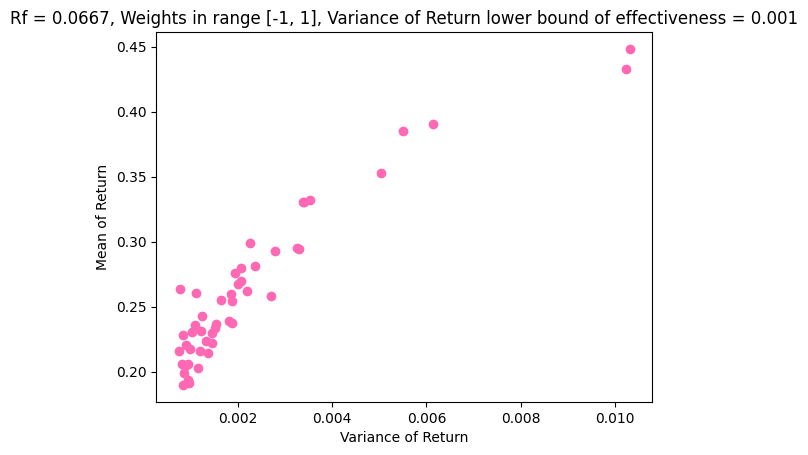

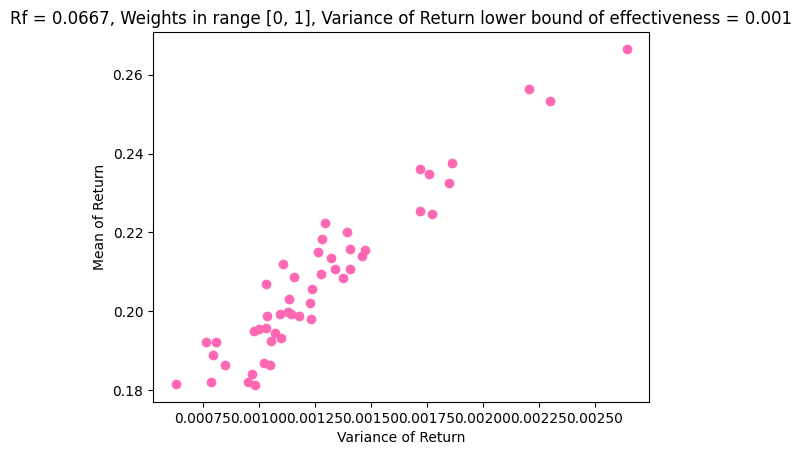

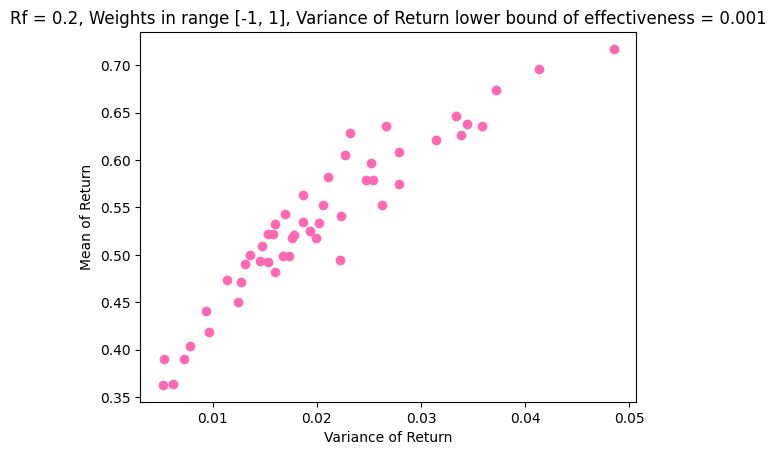

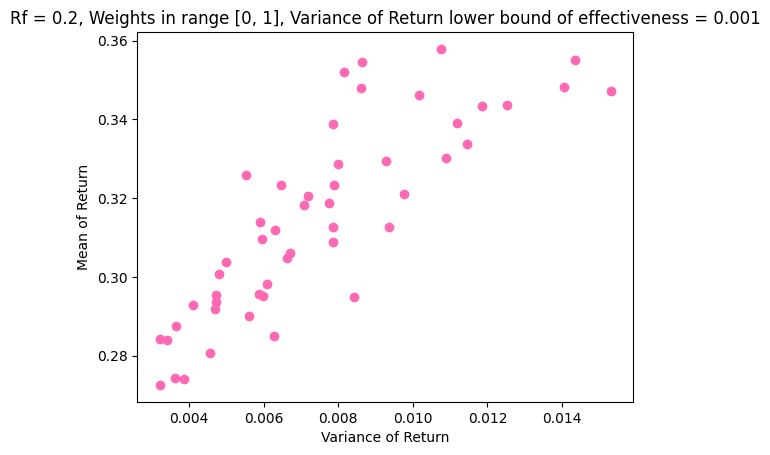

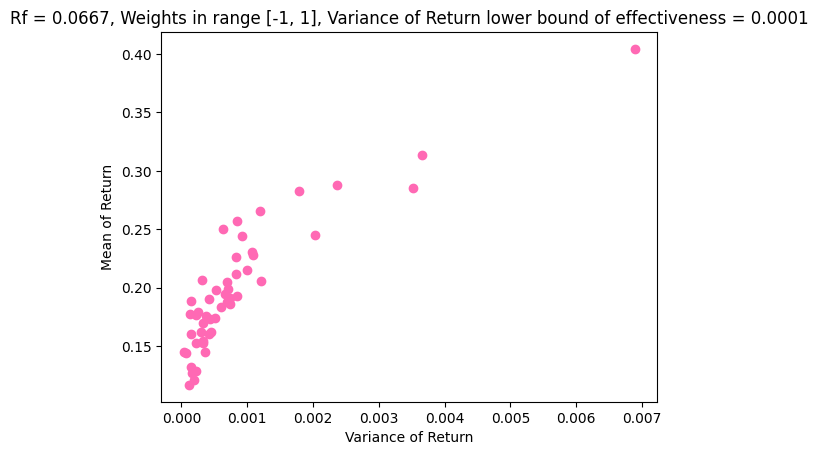

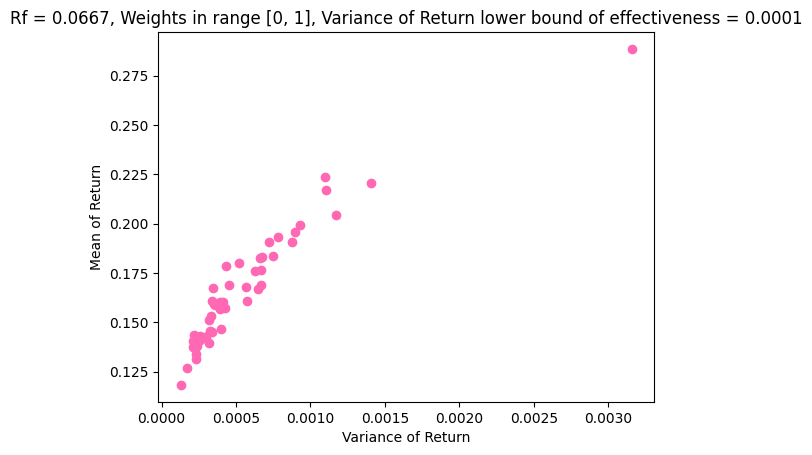

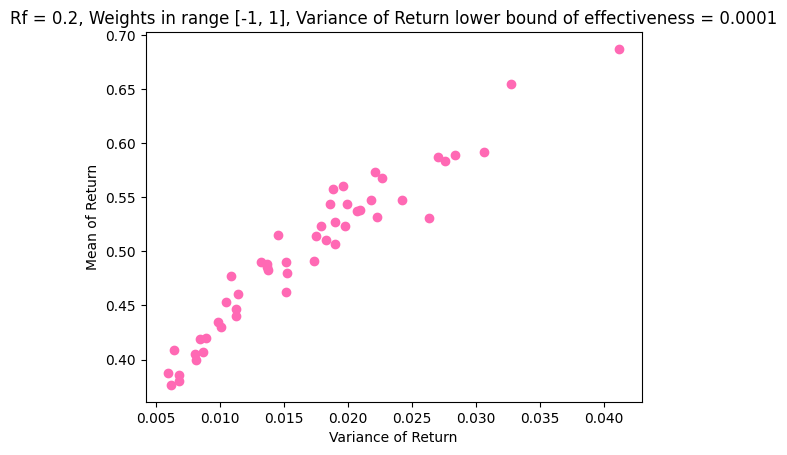

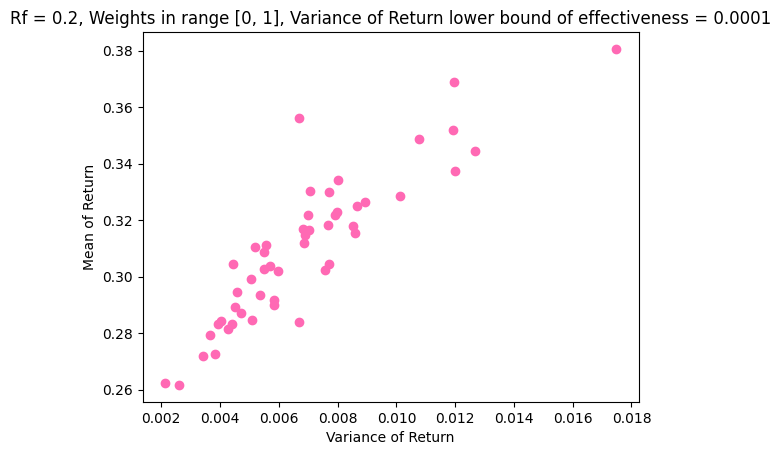

In [13]:
for i in range(8):
    plt.figure()
    plt.xlabel("Variance of Return")
    plt.ylabel("Mean of Return")
    plt.title('Rf = {}, Weights in range [{}, {}], Variance of Return lower bound of effectiveness = {}'.format(parameters[i][0], parameters[i][1], parameters[i][2], parameters[i][3]))
    plt.scatter(solutions[i][:,0], solutions[i][:,1], color = 'hotpink')
plt.show()